# Dependencies

In [1]:
from sys import path
path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.preprocessing import LabelEncoder
from src.mrk_file import MRKFile
from src.iso_standard import PhotographicRequirements
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, Input

%matplotlib inline

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_TRAIN_BOTTLENECKS = 'data/train_bottlenecks.pkl'

FILE_VAL_DUMP = 'data/val_dump.pkl'
FILE_VAL_BOTTLENECKS = 'data/val_bottlenecks.pkl'

INPUT_SHAPE = (224, 224, 3)

In [3]:
output_names = ['blurred', 
                'looking_away', 
                'ink_marked_creased', 
                'unnatural_skin_tone', 
                'too_dark_light', 
                'washed_out', 
                'pixelation', 
                'hair_across_eyes', 
                'eyes_closed', 
                'varied_background', 
                'roll_pitch_yaw', 
                'flash_reflection_on_skin', 
                'red_eyes', 
                'shadows_behind_head', 
                'shadows_across_face', 
                'dark_tinted_lenses', 
                'flash_reflection_on_lenses', 
                'frames_too_heavy', 
                'frame_covering_eyes', 
                'hat_cap', 
                'veil_over_face', 
                'mouth_open', 
                'presence_of_other_faces_or_toys']

# Helper Methods 

In [25]:
def plot_history(history, metric='_loss'):
    from math import ceil
    train_losses = [history[name + metric] for name in output_names]
    val_losses = [history['val_' + name + metric] for name in output_names]

    n_graphs = len(train_losses)
    n_cols = 3
    n_rows = ceil(n_graphs / n_cols)

    plt.figure(figsize=(20, 30))
    for i, (train, val, name) in enumerate(zip(train_losses, val_losses, output_names)):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(train, label='train')
        plt.plot(val, label='val')
        plt.title(name)
        plt.legend()
    plt.tight_layout()

# Load Data 

In [5]:
train_image_files, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))

print(len(train_image_files), type(train_image_files))
print(x_train.shape, x_train.dtype)
print(len(train_mrks), type(train_mrks[0]))

5211 <class 'list'>
(5211, 224, 224, 3) float32
5211 <class 'src.mrk_file.MRKFile'>


In [6]:
val_image_files, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))

print(len(val_image_files), type(val_image_files))
print(x_val.shape, x_val.dtype)
print(len(val_mrks), type(val_mrks[0]))

565 <class 'list'>
(565, 224, 224, 3) float32
565 <class 'src.mrk_file.MRKFile'>


# Save Bottlenecks 

In [7]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [8]:
train_features = base_model.predict(x_train, batch_size=32, verbose=1)
val_features = base_model.predict(x_val, batch_size=32, verbose=1)

print(train_features.shape, train_features.dtype)
print(val_features.shape, val_features.dtype)

565/565 [==============================] - 1s 1ms/step
(5211, 7, 7, 1024) float32
(565, 7, 7, 1024) float32


In [9]:
train_values = np.array([mrk.photo_reqs.values() for mrk in train_mrks], dtype=np.int8)
val_values = np.array([mrk.photo_reqs.values() for mrk in val_mrks], dtype=np.int8)

print(train_values.shape, train_values.dtype)
print(val_values.shape, val_values.dtype)

(5211, 23) int8
(565, 23) int8


In [10]:
pkl.dump((train_features, train_values), open(FILE_TRAIN_BOTTLENECKS, 'wb'), protocol=-1)
pkl.dump((val_features, val_values), open(FILE_VAL_BOTTLENECKS, 'wb'), protocol=-1)

# Transfer Learning 

In [11]:
train_features, train_values = pkl.load(open(FILE_TRAIN_BOTTLENECKS, 'rb'))
val_features, val_values = pkl.load(open(FILE_VAL_BOTTLENECKS, 'rb'))

print(train_features.shape, train_features.dtype)
print(train_values.shape, train_values.dtype)
print(val_features.shape, val_features.dtype)
print(val_values.shape, val_values.dtype)

(5211, 7, 7, 1024) float32
(5211, 23) int8
(565, 7, 7, 1024) float32
(565, 23) int8


In [12]:
# transform reqs values from [-1, 0, 1] => [0, 1, 2]
enc = LabelEncoder()
enc.fit(train_values.ravel())

y_train = enc.transform(train_values.ravel()).reshape(train_values.shape)
y_val = enc.transform(val_values.ravel()).reshape(val_values.shape)

assert(y_train.shape == train_values.shape)
assert(y_val.shape == val_values.shape)
assert(np.all(y_train == train_values + 1))
assert(np.all(y_val == val_values + 1))

In [13]:
inputs = Input(shape=train_features.shape[1:], name='inputs')
avg_pool = GlobalAveragePooling2D()(inputs)

r2 = Dense(units=3, activation='softmax', name=output_names[0])(avg_pool)
r3 = Dense(units=3, activation='softmax', name=output_names[1])(avg_pool)
r4 = Dense(units=3, activation='softmax', name=output_names[2])(avg_pool)
r5 = Dense(units=3, activation='softmax', name=output_names[3])(avg_pool)
r6 = Dense(units=3, activation='softmax', name=output_names[4])(avg_pool)
r7 = Dense(units=3, activation='softmax', name=output_names[5])(avg_pool)
r8 = Dense(units=3, activation='softmax', name=output_names[6])(avg_pool)
r9 = Dense(units=3, activation='softmax', name=output_names[7])(avg_pool)
r10 = Dense(units=3, activation='softmax', name=output_names[8])(avg_pool)
r11 = Dense(units=3, activation='softmax', name=output_names[9])(avg_pool)
r12 = Dense(units=3, activation='softmax', name=output_names[10])(avg_pool)
r13 = Dense(units=3, activation='softmax', name=output_names[11])(avg_pool)
r14 = Dense(units=3, activation='softmax', name=output_names[12])(avg_pool)
r15 = Dense(units=3, activation='softmax', name=output_names[13])(avg_pool)
r16 = Dense(units=3, activation='softmax', name=output_names[14])(avg_pool)
r17 = Dense(units=3, activation='softmax', name=output_names[15])(avg_pool)
r18 = Dense(units=3, activation='softmax', name=output_names[16])(avg_pool)
r19 = Dense(units=3, activation='softmax', name=output_names[17])(avg_pool)
r20 = Dense(units=3, activation='softmax', name=output_names[18])(avg_pool)
r21 = Dense(units=3, activation='softmax', name=output_names[19])(avg_pool)
r22 = Dense(units=3, activation='softmax', name=output_names[20])(avg_pool)
r23 = Dense(units=3, activation='softmax', name=output_names[21])(avg_pool)
r24 = Dense(units=3, activation='softmax', name=output_names[22])(avg_pool)

model = Model(inputs=inputs, 
              outputs=[r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24], 
              name='icaonet')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 7, 7, 1024)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1024)         0           inputs[0][0]                     
__________________________________________________________________________________________________
blurred (Dense)                 (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
looking_away (Dense)            (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
ink_marked

In [15]:
hist = model.fit(train_features, 
                 np.hsplit(y_train, range(1, y_train.shape[1])), 
                 batch_size=32, 
                 epochs=5, 
                 validation_data=(val_features, np.hsplit(y_val, range(1, y_val.shape[1]))))

Train on 5211 samples, validate on 565 samples
Epoch 1/5
5211/5211 [==============================] - 4s 804us/step - loss: 4.6766 - blurred_loss: 0.2549 - looking_away_loss: 0.5116 - ink_marked_creased_loss: 0.0710 - unnatural_skin_tone_loss: 0.1236 - too_dark_light_loss: 0.1098 - washed_out_loss: 0.0029 - pixelation_loss: 0.1767 - hair_across_eyes_loss: 0.1342 - eyes_closed_loss: 0.3330 - varied_background_loss: 0.1383 - roll_pitch_yaw_loss: 0.4604 - flash_reflection_on_skin_loss: 0.2431 - red_eyes_loss: 0.2691 - shadows_behind_head_loss: 0.3707 - shadows_across_face_loss: 0.2106 - dark_tinted_lenses_loss: 0.1085 - flash_reflection_on_lenses_loss: 0.2145 - frames_too_heavy_loss: 0.1346 - frame_covering_eyes_loss: 0.2689 - hat_cap_loss: 0.1232 - veil_over_face_loss: 0.0397 - presence_of_other_faces_or_toys_loss: 0.3685 - mouth_open_loss: 0.0087 - blurred_acc: 0.9052 - looking_away_acc: 0.7975 - ink_marked_creased_acc: 0.9716 - unnatural_skin_tone_acc: 0.9536 - too_dark_light_acc: 0.96

Epoch 4/5
5211/5211 [==============================] - 4s 715us/step - loss: 4.4184 - blurred_loss: 0.2437 - looking_away_loss: 0.4879 - ink_marked_creased_loss: 0.0726 - unnatural_skin_tone_loss: 0.1126 - too_dark_light_loss: 0.0963 - washed_out_loss: 0.0016 - pixelation_loss: 0.1663 - hair_across_eyes_loss: 0.1219 - eyes_closed_loss: 0.3079 - varied_background_loss: 0.1300 - roll_pitch_yaw_loss: 0.4523 - flash_reflection_on_skin_loss: 0.2321 - red_eyes_loss: 0.2520 - shadows_behind_head_loss: 0.3626 - shadows_across_face_loss: 0.1972 - dark_tinted_lenses_loss: 0.0995 - flash_reflection_on_lenses_loss: 0.2022 - frames_too_heavy_loss: 0.1203 - frame_covering_eyes_loss: 0.2542 - hat_cap_loss: 0.1144 - veil_over_face_loss: 0.0358 - presence_of_other_faces_or_toys_loss: 0.3486 - mouth_open_loss: 0.0063 - blurred_acc: 0.9121 - looking_away_acc: 0.8164 - ink_marked_creased_acc: 0.9668 - unnatural_skin_tone_acc: 0.9578 - too_dark_light_acc: 0.9653 - washed_out_acc: 0.9992 - pixelation_acc: 0

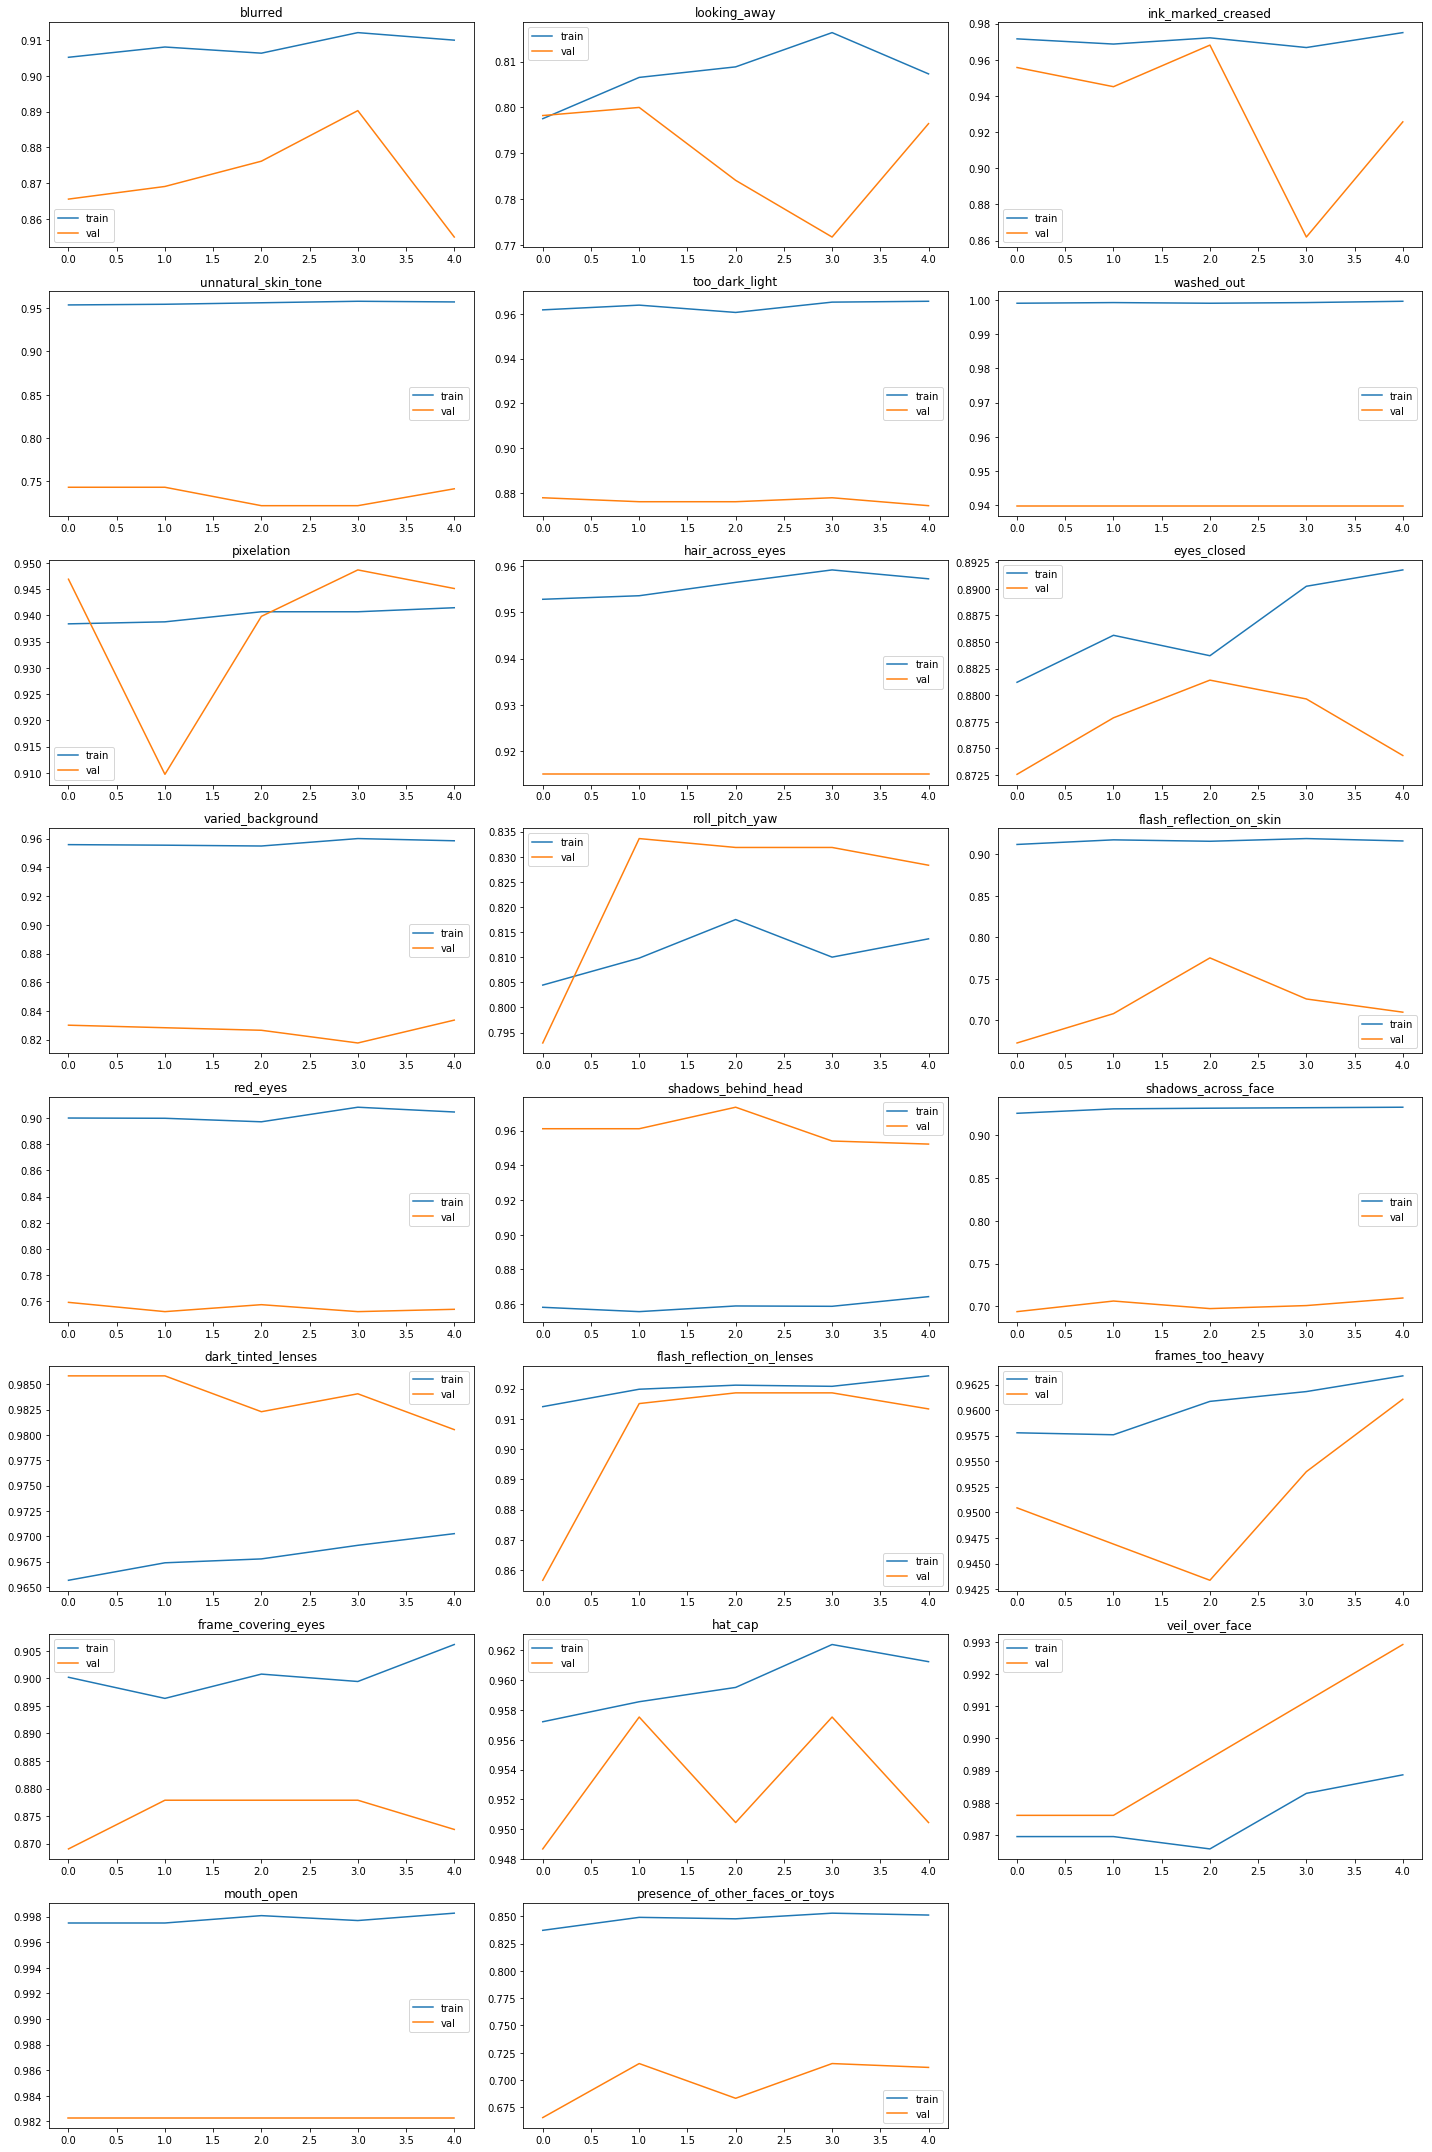

In [28]:
plot_history(hist.history, metric='_acc')